1/1 [==============================] - 0s 53ms/step


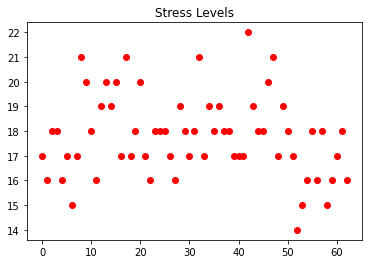

In [2]:
from tkinter import *
from tkinter import messagebox
from tkinter import ttk
import tkinter as tk


from datetime import datetime
import xlwt
from xlwt import Workbook
wb=Workbook()


import PIL
from PIL import ImageTk
from PIL import Image

win=Tk()
win.geometry("700x500")
Label(win,text="Stress Detection through Facial Expressions",font=('Aerial 24 bold italic')).pack(pady=20)
bg=Image.open("download.jpg")
photo=ImageTk.PhotoImage(bg,master=win)

label1=Label(win,image=photo)
label1.place(x=0,y=0,relwidth=1,relheight=1)
label1.image=bg
label1.pack()


def show_img():
    from scipy.spatial import distance as dist
    from imutils.video import VideoStream
    from imutils import face_utils
    import numpy as np
    import imutils
    import time
    import dlib
    import cv2
    import matplotlib.pyplot as plt
#from keras_preprocessing.image import img_to_array
    from tensorflow.keras.utils import img_to_array
    from keras.models import load_model

# function to calculate heart rate
    def calculate_heart_rate(color_signal, fps):
        b, g, r = cv2.split(color_signal)
        roi = g[150:350, 150:350]
        mean_intensity = np.mean(roi)
        heart_rate = mean_intensity * (60 * fps / 512)
        return heart_rate/5

    def ebdist(leye,reye):
        eyedist = dist.euclidean(leye,reye)
        points.append(int(eyedist))
        return eyedist

#calculating lip dostance using facial landmark
    def lpdist(l_lower,l_upper):
        lipdist = dist.euclidean(l_lower, l_upper)
        points_lip.append(int(lipdist))
        return lipdist

#finding stressed or not using the emotions 
    def emotion_finder(faces,frame):
        EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]
        x,y,w,h = face_utils.rect_to_bb(faces)
        frame = frame[y:y+h,x:x+w]
        roi = cv2.resize(frame,(64,64))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0)
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]
        if label in ['scared','sad','angry']:
            label = 'Stressed'
        else:
            label = 'Not Stressed'
        return label

# function to calculate stress level based on heart rate and facial features
    def calculate_stress(points, eyedist, points_lip, lipdist, heart_rate):
    # normalize values
        norm_eyedist = eyedist / np.max(points)
        norm_lipdist = lipdist / np.max(points_lip)
        norm_hr = (heart_rate - 50) / 150
    # calculate stress value
        stress_value = 0.6 * norm_eyedist + 0.3 * norm_lipdist + 0.1 * norm_hr
    # calculate stress level based on stress value
        if stress_value <= 0.33:
            stress_label = "Low"
        elif stress_value <= 0.66:
            stress_label = "Moderate"
        else:
            stress_label = "High"
        return stress_value, stress_label
    global points, points_lip, emotion_classifier, detector, predictor

    emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
    points = []; points_lip=[]

# initialize video stream
    cap = cv2.VideoCapture(0)

# load face detector and facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# initialize heart rate calculation variables
    start_time = time.time()
    frame_count = 0
    color_signal = None

    while(True):    
            ret,frame = cap.read()
            frame = cv2.flip(frame,1)#to rotate img along x-axis and y-axis or both
            frame = imutils.resize(frame, width=500,height=500)#imutils - for resizing,translation,rotation and displaying matplotlib imgs
        #gettting points of eye from the facial landmark
            (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
            (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
        # getting lip points from facial landmarks
            (l_lower, l_upper) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
        #preprocessing the image
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
            detections = detector(gray,0)
            for detection in detections:
                emotion= emotion_finder(detection,gray)
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)#to display emotion
                shape = predictor(frame,detection)
                shape = face_utils.shape_to_np(shape)#used to convert to numpy array which is used to easily detect the facial landmarks
               
                leyebrow = shape[lBegin:lEnd]
                reyebrow = shape[rBegin:rEnd]
                openmouth = shape[l_lower:l_upper]
            # figuring out convex shape 
                reyebrowhull = cv2.convexHull(reyebrow) #eyebrow points are consdered as boundary and points inside form a cluster
                leyebrowhull = cv2.convexHull(leyebrow) #A convex hull encloses a set of points and it acts as a cluster boundary which helps in determining all the points within a cluster.
                openmouthhull = cv2.convexHull(openmouth) 
    
                cv2.drawContours(frame, [reyebrowhull], -1, (0, 255, 0), 1) #the boundary color drawn around the eyebrow
                cv2.drawContours(frame, [leyebrowhull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [openmouthhull], -1, (0, 255, 0), 1)
            
            # Measuring lip distance and eye distance
                
                eyedist = ebdist(leyebrow[-1],reyebrow[0])
                lipdist = lpdist(openmouth[-1],openmouth[0])
                # calculate heart rate
                fps=30
                heart_rate = calculate_heart_rate(frame, fps) 
                
                stress_value,stress_label = calculate_stress(points,eyedist, points_lip, lipdist,heart_rate)
            #displaying stress levels and value 
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (235, 52, 52), 2)
                cv2.putText(frame,"stress value:{}".format(str(int(stress_value*100))),(10,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (51, 66, 232), 2)
                cv2.putText(frame,"Stress level:{}".format((stress_label)),(10,60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (35, 189, 25), 2)
                cv2.putText(frame,"Heart Rate: {} bpm".format(int(heart_rate)), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
 
            
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
    def plt_show():
        plot_stress=plt.plot(range(len(points)),points,'ro')
        plt.title("Stress Levels")
        plt.show()
        return plot_stress
    
    cv2.destroyAllWindows()
    cap.release()
    plt.plot(range(len(points)),points,'ro')
    plt.title("Stress Levels")
    plt.show()
#Label(win,text="Stress Detection!",font=('Aerial 17 bold italic')).pack(pady=20)
tk.Button(win,bg="pink",activebackground="pink",font="arial 24",text="Stress Detection",borderwidth=10,command=show_img).pack(pady=20)
Label(win,text="Tips to tame stress:",font=('Aerial 20 bold italic')).pack(pady=10)
def create_label(text):
    label = tk.Label(win, text=text, wraplength=800, justify="left",font=('Helvetica 12 bold'))
    label.pack(pady=10)

#canvas= Canvas(win, width= 1500, height= 750)
create_label("Breaaatheeee!: Take slow, deep breaths to lower heart rate and blood pressure.")
create_label("Take a quick walk: When you’re feeling overwhelmed go for a quick stroll. You’ll get the benefits of alone time, physical activity, and a few minutes to gather your thoughts.")
create_label("Count Backward!: When worries are running rampant, try slowly counting to 10 and then back again to calm down.")
create_label("Stretch: Stand up for a quick stretch to relieve muscle tension which helps you relax.")
create_label("Write it down buddy: Putting our emotions on paper can make them seem less intimidating, hence try journaling to calm your nerves.")
create_label("Talk to a Friend: When something’s really bothering you, it can help to share your feelings with a buddy. Vent it out!!")

#Add a text in Canvas
#canvas.create_text(text="1. Breaaatheeee!: Take slow, deep breaths to lower heart rate and blood pressure.", fill="black", font=('Helvetica 15 bold'),justify='center')
#canvas.create_text(800, text="2. Take a quick walk: When you’re feeling overwhelmed go for a quick stroll. You’ll get the benefits of alone time, physical activity, and a", fill="black", font=('Helvetica 15 bold'),justify='center')
#canvas.create_text(830, text="few minutes to gather your thoughts.", fill="black", font=('Helvetica 15 bold'),justify='center')

                   #2. Take a quick walk: When you’re feeling overwhelmed go for a quick stroll. You’ll get the benefits of alone time, physical activity, and a few minutes to gather your thoughts.3. Count Backward!: When worries are running rampant, try slowly counting to 10 and then back again to calm down.4. Stretch: Stand up for a quick stretch to relieve muscle tension which helps you relax.5. Write it down buddy: Putting our emotions on paper can make them seem less intimidating, hence try journaling to calm your nerves.6. Talk to a Friend: When something’s really bothering you, it can help to share your feelings with a buddy. Vent it out!!", fill="black", font=('Helvetica 15 bold'),justify='center')

#canvas.pack()

win.mainloop()

In [2]:
pip install numpy==1.21

Note: you may need to restart the kernel to use updated packages.


'C:\Users\JOY' is not recognized as an internal or external command,
operable program or batch file.


In [65]:
!pip install xlwt


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from tkinter import *
from tkinter import messagebox
from tkinter import ttk
import tkinter as tk
import webbrowser
import statistics
import html

from datetime import datetime
import xlwt
from xlwt import Workbook
wb=Workbook()


import PIL
from PIL import ImageTk
from PIL import Image

win=Tk()
win.geometry("700x500")
Label(win,bg='#f5e4ef',text="Stress Detection through Facial Expressions",font=('Aerial 24 bold italic')).pack(pady=20)
bg=Image.open("download.jpg")
photo=ImageTk.PhotoImage(bg,master=win)


label1=Label(win,image=photo)
label1.place(x=0,y=0,relwidth=1,relheight=1)
label1.image=bg
label1.pack()

label = Label(win,bg="#f5e4ef",borderwidth=3,font=('Aerial 20 bold italic'))
label.pack()

label2 = Label(win,bg="#f5e4ef",borderwidth=3,font=('Aerial 20 bold italic'))
label2.pack()

stress_labels = []

#average_stress_value=0
def show_img():
    from scipy.spatial import distance as dist
    from imutils.video import VideoStream
    from imutils import face_utils
    import numpy as np
    import imutils
    import time
    import dlib
    import cv2
    import matplotlib.pyplot as plt
#from keras_preprocessing.image import img_to_array
    from tensorflow.keras.utils import img_to_array
    from keras.models import load_model

# function to calculate heart rate
    def calculate_heart_rate(color_signal, fps):
        b, g, r = cv2.split(color_signal)
        roi = g[150:350, 150:350]
        mean_intensity = np.mean(roi)
        heart_rate = mean_intensity * (60 * fps / 512)
        return heart_rate/5

    def ebdist(leye,reye):
        eyedist = dist.euclidean(leye,reye)
        points.append(int(eyedist))
        return eyedist

#calculating lip dostance using facial landmark
    def lpdist(l_lower,l_upper):
        lipdist = dist.euclidean(l_lower, l_upper)
        points_lip.append(int(lipdist))
        return lipdist
    emotions = []
#finding stressed or not using the emotions 
    def emotion_finder(faces,frame):
        EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]
        x,y,w,h = face_utils.rect_to_bb(faces)
        frame = frame[y:y+h,x:x+w]
        roi = cv2.resize(frame,(64,64))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0)
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]
        if label in ['scared','sad','angry']:
            label = 'Stressed'
        else:
            label = 'Not Stressed'
        
        return label
    stress_values = []
    
# function to calculate stress level based on heart rate and facial features
    def calculate_stress(points, eyedist, points_lip, lipdist, heart_rate):
    # normalize values
        norm_eyedist = eyedist / np.max(points)
        norm_lipdist = lipdist / np.max(points_lip)
        norm_hr = (heart_rate - 50) / 150
    # calculate stress value
        stress_value = 0.6 * norm_eyedist + 0.3 * norm_lipdist + 0.1 * norm_hr
        
        stress_values.append(stress_value)
        
    # calculate stress level based on stress value
        if stress_value <= 0.66:
            stress_label = "Low"
        elif stress_value <= 0.80:
            stress_label = "Moderate"
        else:
            stress_label = "High"
        return stress_value, stress_label
    global points, points_lip, emotion_classifier, detector, predictor,average_stress_value

    emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
    points = []; points_lip=[]

# initialize video stream
    cap = cv2.VideoCapture(0)

# load face detector and facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# initialize heart rate calculation variables
    start_time = time.time()
    frame_count = 0
    color_signal = None
    
    total_stress_value = 0
    num_frames = 0
    stress_label = ""
    while(True):    
            ret,frame = cap.read()
            frame = cv2.flip(frame,1)#to rotate img along x-axis and y-axis or both
            frame = imutils.resize(frame, width=500,height=500)#imutils - for resizing,translation,rotation and displaying matplotlib imgs
        #gettting points of eye from the facial landmark
            (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
            (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
        # getting lip points from facial landmarks
            (l_lower, l_upper) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
        #preprocessing the image
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
            detections = detector(gray,0)
            for detection in detections:
                emotion= emotion_finder(detection,gray)
                emotions.append(emotion)
                #label2.config(text=emotion)
                #label2.update()
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)#to display emotion
                shape = predictor(frame,detection)
                shape = face_utils.shape_to_np(shape)#used to convert to numpy array which is used to easily detect the facial landmarks
               
                leyebrow = shape[lBegin:lEnd]
                reyebrow = shape[rBegin:rEnd]
                openmouth = shape[l_lower:l_upper]
            # figuring out convex shape 
                reyebrowhull = cv2.convexHull(reyebrow) #eyebrow points are consdered as boundary and points inside form a cluster
                leyebrowhull = cv2.convexHull(leyebrow) #A convex hull encloses a set of points and it acts as a cluster boundary which helps in determining all the points within a cluster.
                openmouthhull = cv2.convexHull(openmouth) 
    
                cv2.drawContours(frame, [reyebrowhull], -1, (0, 255, 0), 1) #the boundary color drawn around the eyebrow
                cv2.drawContours(frame, [leyebrowhull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [openmouthhull], -1, (0, 255, 0), 1)
            
            # Measuring lip distance and eye distance
                
                eyedist = ebdist(leyebrow[-1],reyebrow[0])
                lipdist = lpdist(openmouth[-1],openmouth[0])
                # calculate heart rate
                fps=30
                heart_rate = calculate_heart_rate(frame, fps) 
                
                stress_value,stress_label = calculate_stress(points,eyedist, points_lip, lipdist,heart_rate)
                stress_labels.append(stress_label)
            #displaying stress levels and value 
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (235, 52, 52), 2)
                cv2.putText(frame,"stress value:{}".format(str(int(stress_value*100))),(10,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (51, 66, 232), 2)
                cv2.putText(frame,"Stress level:{}".format((stress_label)),(10,60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (35, 189, 25), 2)
                cv2.putText(frame,"Heart Rate: {} bpm".format(int(heart_rate)), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
                total_stress_value += stress_value
                num_frames += 1

            
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
                
            
    def plt_show():
        plot_stress=plt.plot(range(len(points)),points,'ro')
        plt.title("Stress Levels")
        plt.show()
        return plot_stress
    
    if num_frames > 0:
        avg_stress_value = total_stress_value / num_frames
        print('Average stress value:', avg_stress_value)
        #return avg_stress_value
    
    mode_emotion = statistics.mode(emotions)
    # create label widget to display mode of emotions
    #label = Label(win,bg="#f5e4ef", text="You're ",borderwidth=5,font=('Aerial 20 bold italic'))
    #label.pack()

    # update label with mode of emotions
    label.config(text="You're : " + mode_emotion)
    #mode_stress_label = stats.mode(stress_labels)
    #mode_label = Label(win, text="Mode of stress labels: " + mode_stress_label)
    #mode_label.pack()
    # calculate and print average stress value
    
    if mode_emotion== 'Stressed':
        mode_stress_label = statistics.mode(stress_labels)
        label2.config(text="Stress level: " + mode_stress_label)
    else:
        label2.config(text="You're perfect example for not stressing over things you can't control.")
        
        
    cv2.destroyAllWindows()
    cap.release()
    plt.plot(range(len(points)),points,'ro')
    plt.title("Stress Levels")
    plt.show()
#Label(win,text="Stress Detection!",font=('Aerial 17 bold italic')).pack(pady=20)


win.configure(bg='#f5e4ef')

    
tk.Button(win,bg="pink",font="arial 24",text="Stress Detection",borderwidth=10,command=show_img).pack(pady=20)

'''stress_label_var = tk.StringVar()
stress_label_var.set("Stress level: ")
stress_label = Label(win, textvariable=stress_label_var, font=('Arial 18 bold'), fg='#0a097a', bg='#f5e4ef')
stress_label.pack(pady=20)'''

def open_link(url):
    webbrowser.open_new_tab(url)
    
#tk.Button(win,bg="pink",text="Moderate?",borderwidth=5,command=lambda: open_link("moderate.html")).pack(side="top",pady=0)
#tk.Button(win,bg="pink",text="High?",borderwidth=5,command=lambda: open_link("https://www.google.com")).pack(side="top",pady=0)
'''label = tk.Label(win, text="Average stress value: ")

# Update the label text when needed
def update_label():
    label.config(text="Average stress value: {}".format(average_stress_value))

# Call the update_label function to update the label text
update_label()

# Add the label widget to the Tkinter window
label.pack()'''

tk.Label(win,bg='#f5e4ef', text="", height=1).pack()
Label(win,bg='#f5e4ef',text="Tips to tame stress:",font=('Aerial 20 bold italic')).pack(pady=10)

def create_label(text):
    label = tk.Label(win,bg='#f5e4ef', text=text, wraplength=1100, justify="center",font=('Helvetica 12 bold',15))
    label.pack(pady=10)

#canvas= Canvas(win, width= 1500, height= 750)
create_label("Breaaatheeee!: Take slow, deep breaths to lower heart rate and blood pressure.")
create_label("Take a quick walk: When you’re feeling overwhelmed go for a quick stroll. You’ll get the benefits of alone time, physical activity, and a few minutes to gather your thoughts.")
create_label("Count Backward!: When worries are running rampant, try slowly counting to 10 and then back again to calm down.")
create_label("Stretch: Stand up for a quick stretch to relieve muscle tension which helps you relax.")
#create_label("Write it down buddy: Putting our emotions on paper can make them seem less intimidating, hence try journaling to calm your nerves.")
#create_label("Talk to a Friend: When something’s really bothering you, it can help to share your feelings with a buddy. Vent it out!!")



win.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\JOY PRINCY\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "<ipython-input-3-23c23684bc9d>", line 51, in show_img
    from tensorflow.keras.utils import img_to_array
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\__init__.py", line 37, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\python\__init__.py", line 45, in <module>
    from tensorflow.python.feature_column import feature_column_lib as feature_column
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_lib.py", line 18, in <module>
    from tensorflow.python.feature_column.feature_column import *
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column.py", line 143, in <module>
    from t

In [5]:
from tkinter import *
from tkinter import messagebox
from tkinter import ttk
import tkinter as tk
import webbrowser
import statistics
import html

from datetime import datetime
import xlwt
from xlwt import Workbook
wb=Workbook()


import PIL
from PIL import ImageTk
from PIL import Image

win=Tk()
win.geometry("700x500")
Label(win,bg='#f5e4ef',text="Stress Detection through Facial Expressions",font=('Aerial 24 bold italic')).pack(pady=20)
bg=Image.open("download.jpg")
photo=ImageTk.PhotoImage(bg,master=win)


label1=Label(win,image=photo)
label1.place(x=0,y=0,relwidth=1,relheight=1)
label1.image=bg
label1.pack()

label = Label(win,bg="#f5e4ef",borderwidth=3,font=('Aerial 20 bold italic'))
label.pack()

label2 = Label(win,bg="#f5e4ef",borderwidth=3,font=('Aerial 20 bold italic'))
label2.pack()

stress_labels = []

#average_stress_value=0
def show_img():
    from scipy.spatial import distance as dist
    from imutils.video import VideoStream
    from imutils import face_utils
    import numpy as np
    import imutils
    import time
    import dlib
    import cv2
    import matplotlib.pyplot as plt
#from keras_preprocessing.image import img_to_array
    from tensorflow.keras.utils import img_to_array
    from keras.models import load_model

# function to calculate heart rate
    def calculate_heart_rate(color_signal, fps):
        b, g, r = cv2.split(color_signal)
        roi = g[150:350, 150:350]
        mean_intensity = np.mean(roi)
        heart_rate = mean_intensity * (60 * fps / 512)
        return heart_rate/5

    def ebdist(leye,reye):
        eyedist = dist.euclidean(leye,reye)
        points.append(int(eyedist))
        return eyedist

#calculating lip dostance using facial landmark
    def lpdist(l_lower,l_upper):
        lipdist = dist.euclidean(l_lower, l_upper)
        points_lip.append(int(lipdist))
        return lipdist
    emotions = []
#finding stressed or not using the emotions 
    def emotion_finder(faces,frame):
        EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]
        x,y,w,h = face_utils.rect_to_bb(faces)
        frame = frame[y:y+h,x:x+w]
        roi = cv2.resize(frame,(64,64))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0)
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]
        if label in ['scared','sad','angry']:
            label = 'Stressed'
        else:
            label = 'Not Stressed'
        
        return label
    stress_values = []
    
# function to calculate stress level based on heart rate and facial features
    def calculate_stress(points, eyedist, points_lip, lipdist, heart_rate):
    # normalize values
        norm_eyedist = eyedist / np.max(points)
        norm_lipdist = lipdist / np.max(points_lip)
        norm_hr = (heart_rate - 50) / 150
    # calculate stress value
        stress_value = 0.6 * norm_eyedist + 0.3 * norm_lipdist + 0.1 * norm_hr
        
        stress_values.append(stress_value)
        
    # calculate stress level based on stress value
        if stress_value <= 0.66:
            stress_label = "Low"
        elif stress_value <= 0.80:
            stress_label = "Moderate"
        else:
            stress_label = "High"
        return stress_value, stress_label
    global points, points_lip, emotion_classifier, detector, predictor,average_stress_value

    emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
    points = []; points_lip=[]

# initialize video stream
    cap = cv2.VideoCapture(0)

# load face detector and facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# initialize heart rate calculation variables
    start_time = time.time()
    frame_count = 0
    color_signal = None
    
    total_stress_value = 0
    num_frames = 0
    stress_label = ""
    while(True):    
            ret,frame = cap.read()
            frame = cv2.flip(frame,1)#to rotate img along x-axis and y-axis or both
            frame = imutils.resize(frame, width=500,height=500)#imutils - for resizing,translation,rotation and displaying matplotlib imgs
        #gettting points of eye from the facial landmark
            (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
            (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
        # getting lip points from facial landmarks
            (l_lower, l_upper) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
        #preprocessing the image
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
            detections = detector(gray,0)
            for detection in detections:
                emotion= emotion_finder(detection,gray)
                emotions.append(emotion)
                #label2.config(text=emotion)
                #label2.update()
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)#to display emotion
                shape = predictor(frame,detection)
                shape = face_utils.shape_to_np(shape)#used to convert to numpy array which is used to easily detect the facial landmarks
               
                leyebrow = shape[lBegin:lEnd]
                reyebrow = shape[rBegin:rEnd]
                openmouth = shape[l_lower:l_upper]
            # figuring out convex shape 
                reyebrowhull = cv2.convexHull(reyebrow) #eyebrow points are consdered as boundary and points inside form a cluster
                leyebrowhull = cv2.convexHull(leyebrow) #A convex hull encloses a set of points and it acts as a cluster boundary which helps in determining all the points within a cluster.
                openmouthhull = cv2.convexHull(openmouth) 
    
                cv2.drawContours(frame, [reyebrowhull], -1, (0, 255, 0), 1) #the boundary color drawn around the eyebrow
                cv2.drawContours(frame, [leyebrowhull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [openmouthhull], -1, (0, 255, 0), 1)
            
            # Measuring lip distance and eye distance
                
                eyedist = ebdist(leyebrow[-1],reyebrow[0])
                lipdist = lpdist(openmouth[-1],openmouth[0])
                # calculate heart rate
                fps=30
                heart_rate = calculate_heart_rate(frame, fps) 
                
                stress_value,stress_label = calculate_stress(points,eyedist, points_lip, lipdist,heart_rate)
                stress_labels.append(stress_label)
            #displaying stress levels and value 
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (235, 52, 52), 2)
                cv2.putText(frame,"stress value:{}".format(str(int(stress_value*100))),(10,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (51, 66, 232), 2)
                cv2.putText(frame,"Stress level:{}".format((stress_label)),(10,60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (35, 189, 25), 2)
                cv2.putText(frame,"Heart Rate: {} bpm".format(int(heart_rate)), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
                total_stress_value += stress_value
                num_frames += 1

            
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
                
            
    def plt_show():
        plot_stress=plt.plot(range(len(points)),points,'ro')
        plt.title("Stress Levels")
        plt.show()
        return plot_stress
    
    if num_frames > 0:
        avg_stress_value = total_stress_value / num_frames
        print('Average stress value:', avg_stress_value)
        #return avg_stress_value
    
    mode_emotion = statistics.mode(emotions)
    # create label widget to display mode of emotions
    #label = Label(win,bg="#f5e4ef", text="You're ",borderwidth=5,font=('Aerial 20 bold italic'))
    #label.pack()

    # update label with mode of emotions
    label.config(text="You're : " + mode_emotion)
    #mode_stress_label = stats.mode(stress_labels)
    #mode_label = Label(win, text="Mode of stress labels: " + mode_stress_label)
    #mode_label.pack()
    # calculate and print average stress value
    
    if mode_emotion== 'Stressed':
        mode_stress_label = statistics.mode(stress_labels)
        label2.config(text="Stress level: " + mode_stress_label)
        label3.config(text="Breaaatheeee!: Take slow, deep breaths to lower heart rate and blood pressure.")
    else:
        label2.config(text="You're perfect example for not stressing over things you can't control.")
        
        
    cv2.destroyAllWindows()
    cap.release()
    plt.plot(range(len(points)),points,'ro')
    plt.title("Stress Levels")
    plt.show()
#Label(win,text="Stress Detection!",font=('Aerial 17 bold italic')).pack(pady=20)


win.configure(bg='#f5e4ef')

    
tk.Button(win,bg="pink",font="arial 24",text="Stress Detection",borderwidth=10,command=show_img).pack(pady=20)

'''stress_label_var = tk.StringVar()
stress_label_var.set("Stress level: ")
stress_label = Label(win, textvariable=stress_label_var, font=('Arial 18 bold'), fg='#0a097a', bg='#f5e4ef')
stress_label.pack(pady=20)'''

def open_link(url):
    webbrowser.open_new_tab(url)
    
#tk.Button(win,bg="pink",text="Moderate?",borderwidth=5,command=lambda: open_link("moderate.html")).pack(side="top",pady=0)
#tk.Button(win,bg="pink",text="High?",borderwidth=5,command=lambda: open_link("https://www.google.com")).pack(side="top",pady=0)
'''label = tk.Label(win, text="Average stress value: ")

# Update the label text when needed
def update_label():
    label.config(text="Average stress value: {}".format(average_stress_value))

# Call the update_label function to update the label text
update_label()

# Add the label widget to the Tkinter window
label.pack()'''

tk.Label(win,bg='#f5e4ef', text="", height=1).pack()
Label(win,bg='#f5e4ef',text="Tips to tame stress:",font=('Aerial 20 bold italic')).pack(pady=10)

def create_label(text):
    label = tk.Label(win,bg='#f5e4ef', text=text, wraplength=1100, justify="center",font=('Helvetica 12 bold',15))
    label.pack(pady=10)

#canvas= Canvas(win, width= 1500, height= 750)
create_label("Breaaatheeee!: Take slow, deep breaths to lower heart rate and blood pressure.")
create_label("Take a quick walk: When you’re feeling overwhelmed go for a quick stroll. You’ll get the benefits of alone time, physical activity, and a few minutes to gather your thoughts.")
create_label("Count Backward!: When worries are running rampant, try slowly counting to 10 and then back again to calm down.")
create_label("Stretch: Stand up for a quick stretch to relieve muscle tension which helps you relax.")
#create_label("Write it down buddy: Putting our emotions on paper can make them seem less intimidating, hence try journaling to calm your nerves.")
#create_label("Talk to a Friend: When something’s really bothering you, it can help to share your feelings with a buddy. Vent it out!!")



win.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\JOY PRINCY\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "<ipython-input-5-54de4e9eb4f8>", line 51, in show_img
    from tensorflow.keras.utils import img_to_array
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\__init__.py", line 37, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\python\__init__.py", line 45, in <module>
    from tensorflow.python.feature_column import feature_column_lib as feature_column
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_lib.py", line 18, in <module>
    from tensorflow.python.feature_column.feature_column import *
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column.py", line 143, in <module>
    from t

In [8]:
import tkinter as tk

# create a tkinter window
win = tk.Tk()

# create a canvas
canvas = tk.Canvas(win)
canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

# create a scrollbar
scrollbar = tk.Scrollbar(win, orient=tk.VERTICAL, command=canvas.yview)
scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

# configure the canvas to use the scrollbar
canvas.configure(yscrollcommand=scrollbar.set)

# create a frame inside the canvas to hold the widgets
frame = tk.Frame(canvas)
canvas.create_window((0, 0), window=frame, anchor="nw")

# add widgets to the frame
for i in range(20):
    tk.Label(frame, text=f"Label {i}").pack()

# configure the canvas to resize when the frame is resized
frame.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

# run the tkinter event loop
win.mainloop()


In [1]:
from tkinter import *
from tkinter import messagebox
from tkinter import ttk
import tkinter as tk
import webbrowser

from datetime import datetime
import xlwt
from xlwt import Workbook
wb=Workbook()


import PIL
from PIL import ImageTk
from PIL import Image

win=Tk()
win.geometry("700x500")
Label(win,bg='#f5e4ef',text="Stress Detection through Facial Expressions",font=('Aerial 24 bold italic')).pack(pady=20)
bg=Image.open("download.jpg")
photo=ImageTk.PhotoImage(bg,master=win)

label1=Label(win,image=photo)
label1.place(x=0,y=0,relwidth=1,relheight=1)
label1.image=bg
label1.pack()

#average_stress_value=0
def show_img():
    from scipy.spatial import distance as dist
    from imutils.video import VideoStream
    from imutils import face_utils
    import numpy as np
    import imutils
    import time
    import dlib
    import cv2
    import matplotlib.pyplot as plt
#from keras_preprocessing.image import img_to_array
    from tensorflow.keras.utils import img_to_array
    from keras.models import load_model

# function to calculate heart rate
    def calculate_heart_rate(color_signal, fps):
        b, g, r = cv2.split(color_signal)
        roi = g[150:350, 150:350]
        mean_intensity = np.mean(roi)
        heart_rate = mean_intensity * (60 * fps / 512)
        return heart_rate/5

    def ebdist(leye,reye):
        eyedist = dist.euclidean(leye,reye)
        points.append(int(eyedist))
        return eyedist

#calculating lip dostance using facial landmark
    def lpdist(l_lower,l_upper):
        lipdist = dist.euclidean(l_lower, l_upper)
        points_lip.append(int(lipdist))
        return lipdist

#finding stressed or not using the emotions 
    def emotion_finder(faces,frame):
        EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]
        x,y,w,h = face_utils.rect_to_bb(faces)
        frame = frame[y:y+h,x:x+w]
        roi = cv2.resize(frame,(64,64))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0)
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]
        if label in ['scared','sad','angry']:
            label = 'Stressed'
        else:
            label = 'Not Stressed'
        return label
    stress_values = []
# function to calculate stress level based on heart rate and facial features
    def calculate_stress(points, eyedist, points_lip, lipdist, heart_rate):
    # normalize values
        norm_eyedist = eyedist / np.max(points)
        norm_lipdist = lipdist / np.max(points_lip)
        norm_hr = (heart_rate - 50) / 150
    # calculate stress value
        stress_value = 0.6 * norm_eyedist + 0.3 * norm_lipdist + 0.1 * norm_hr
        
        stress_values.append(stress_value)
    # calculate stress level based on stress value
        if stress_value <= 0.60:
            stress_label = "Low"
        elif stress_value <= 0.90:
            stress_label = "Moderate"
        else:
            stress_label = "High"
        return stress_value, stress_label
    global points, points_lip, emotion_classifier, detector, predictor,average_stress_value

    emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
    points = []; points_lip=[]

# initialize video stream
    cap = cv2.VideoCapture(0)

# load face detector and facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# initialize heart rate calculation variables
    start_time = time.time()
    frame_count = 0
    color_signal = None
    
    total_stress_value = 0
    num_frames = 0
    stress_label = ""
    while(True):    
            ret,frame = cap.read()
            frame = cv2.flip(frame,1)#to rotate img along x-axis and y-axis or both
            frame = imutils.resize(frame, width=500,height=500)#imutils - for resizing,translation,rotation and displaying matplotlib imgs
        #gettting points of eye from the facial landmark
            (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
            (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
        # getting lip points from facial landmarks
            (l_lower, l_upper) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
        #preprocessing the image
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
            detections = detector(gray,0)
            for detection in detections:
                emotion= emotion_finder(detection,gray)
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                #to display emotion
                shape = predictor(frame,detection)
                shape = face_utils.shape_to_np(shape)
                #used to convert to numpy array which is used to easily detect the facial landmarks
               
                leyebrow = shape[lBegin:lEnd]
                reyebrow = shape[rBegin:rEnd]
                openmouth = shape[l_lower:l_upper]
            # figuring out convex shape 
                reyebrowhull = cv2.convexHull(reyebrow) #eyebrow points are consdered as boundary and points
                #inside form a cluster
                leyebrowhull = cv2.convexHull(leyebrow) #A convex hull encloses a set of points and
                #it acts as a cluster boundary which helps in determining all the points within a cluster.
                openmouthhull = cv2.convexHull(openmouth) 
    
                cv2.drawContours(frame, [reyebrowhull], -1, (0, 255, 0), 1) #the boundary color drawn 
                #around the eyebrow
                cv2.drawContours(frame, [leyebrowhull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [openmouthhull], -1, (0, 255, 0), 1)
            
            # Measuring lip distance and eye distance
                
                eyedist = ebdist(leyebrow[-1],reyebrow[0])
                lipdist = lpdist(openmouth[-1],openmouth[0])
                # calculate heart rate
                fps=30
                heart_rate = calculate_heart_rate(frame, fps) 
                
                stress_value,stress_label = calculate_stress(points,eyedist, points_lip, lipdist,heart_rate)
                stress_label_var.set("Stress level: " + stress_label)
            #displaying stress levels and value 
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (235, 52, 52), 2)
                cv2.putText(frame,"stress value:{}".format(str(int(stress_value*100))),(10,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (51, 66, 232), 2)
                cv2.putText(frame,"Stress level:{}".format((stress_label)),(10,60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (35, 189, 25), 2)
                cv2.putText(frame,"Heart Rate: {} bpm".format(int(heart_rate)), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
                total_stress_value += stress_value
                num_frames += 1

            
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
                
            
    def plt_show():
        plot_stress=plt.plot(range(len(points)),points,'ro')
        plt.title("Stress Levels")
        plt.show()
        return plot_stress
    
    # calculate and print average stress value
    if num_frames > 0:
        avg_stress_value = total_stress_value / num_frames
        print('Average stress value:', avg_stress_value)
        #return avg_stress_value
    
    cv2.destroyAllWindows()
    cap.release()
    plt.plot(range(len(points)),points,'ro')
    plt.title("Stress Levels")
    plt.show()
#Label(win,text="Stress Detection!",font=('Aerial 17 bold italic')).pack(pady=20)
    
win.configure(bg='#f5e4ef')
tk.Button(win,bg="pink",font="arial 24",text="Stress Detection",borderwidth=10,command=show_img).pack(pady=20)

stress_label_var = tk.StringVar()
stress_label_var.set("Stress level: ")
stress_label = Label(win, textvariable=stress_label_var, font=('Arial 18 bold'), fg='#0a097a', bg='#f5e4ef')
stress_label.pack(pady=20)

'''label = tk.Label(win, text="Average stress value: ")

# Update the label text when needed
def update_label():
    label.config(text="Average stress value: {}".format(average_stress_value))

# Call the update_label function to update the label text
update_label()

# Add the label widget to the Tkinter window
label.pack()'''


Label(win,bg='#f5e4ef',text="Tips to tame stress:",font=('Aerial 20 bold italic')).pack(pady=10)

def create_label(text):
    label = tk.Label(win,bg='#f5e4ef', text=text, wraplength=1100, justify="center",font=('Helvetica 12 bold',15))
    label.pack(pady=10)

#canvas= Canvas(win, width= 1500, height= 750)
create_label("Breaaatheeee!: Take slow, deep breaths to lower heart rate and blood pressure.")
create_label("Take a quick walk: When you’re feeling overwhelmed go for a quick stroll. You’ll get the benefits of alone time, physical activity, and a few minutes to gather your thoughts.")
create_label("Count Backward!: When worries are running rampant, try slowly counting to 10 and then back again to calm down.")
create_label("Stretch: Stand up for a quick stretch to relieve muscle tension which helps you relax.")
#create_label("Write it down buddy: Putting our emotions on paper can make them seem less intimidating, hence try journaling to calm your nerves.")
#create_label("Talk to a Friend: When something’s really bothering you, it can help to share your feelings with a buddy. Vent it out!!")



#canvas.pack()

win.mainloop()

C:\Users\JOY PRINCY\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\JOY PRINCY\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "<ipython-input-1-59783dcdd517>", line 40, in show_img
    from tensorflow.keras.utils import img_to_array
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\__init__.py", line 37, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\python\__init__.py", line 45, in <module>
    from tensorflow.python.feature_column import feature_column_lib as feature_column
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-pa

In [8]:
from tkinter import *
from tkinter import messagebox
from tkinter import ttk
import tkinter as tk
import webbrowser

from datetime import datetime
import xlwt
from xlwt import Workbook
wb=Workbook()


import PIL
from PIL import ImageTk
from PIL import Image

win=Tk()
win.geometry("700x500")
Label(win,bg='#f5e4ef',text="Stress Detection through Facial Expressions",font=('Aerial 24 bold italic')).pack(pady=20)
bg=Image.open("download.jpg")
photo=ImageTk.PhotoImage(bg,master=win)

label1=Label(win,image=photo)
label1.place(x=0,y=0,relwidth=1,relheight=1)
label1.image=bg
label1.pack()

#average_stress_value=0
def show_img():
    from scipy.spatial import distance as dist
    from imutils.video import VideoStream
    from imutils import face_utils
    import numpy as np
    import imutils
    import time
    import dlib
    import cv2
    import matplotlib.pyplot as plt
#from keras_preprocessing.image import img_to_array
    from tensorflow.keras.utils import img_to_array
    from keras.models import load_model

# function to calculate heart rate
    def calculate_heart_rate(color_signal, fps):
        b, g, r = cv2.split(color_signal)
        roi = g[150:350, 150:350]
        mean_intensity = np.mean(roi)
        heart_rate = mean_intensity * (60 * fps / 512)
        return heart_rate/5

    def ebdist(leye,reye):
        eyedist = dist.euclidean(leye,reye)
        points.append(int(eyedist))
        return eyedist

#calculating lip dostance using facial landmark
    def lpdist(l_lower,l_upper):
        lipdist = dist.euclidean(l_lower, l_upper)
        points_lip.append(int(lipdist))
        return lipdist

#finding stressed or not using the emotions 
    def emotion_finder(faces,frame):
        EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]
        x,y,w,h = face_utils.rect_to_bb(faces)
        frame = frame[y:y+h,x:x+w]
        roi = cv2.resize(frame,(64,64))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0)
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]
        if label in ['scared','sad','angry']:
            label = 'Stressed'
        else:
            label = 'Not Stressed'
        return label
    stress_values = []
# function to calculate stress level based on heart rate and facial features
    def calculate_stress(points, eyedist, points_lip, lipdist, heart_rate):
    # normalize values
        norm_eyedist = eyedist / np.max(points)
        norm_lipdist = lipdist / np.max(points_lip)
        norm_hr = (heart_rate - 50) / 150
    # calculate stress value
        stress_value = 0.6 * norm_eyedist + 0.3 * norm_lipdist + 0.1 * norm_hr
        
        stress_values.append(stress_value)
    # calculate stress level based on stress value
        if stress_value <= 0.60:
            stress_label = "Low"
        elif stress_value <= 0.90:
            stress_label = "Moderate"
        else:
            stress_label = "High"
        return stress_value, stress_label
    global points, points_lip, emotion_classifier, detector, predictor,average_stress_value

    emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
    points = []; points_lip=[]

# initialize video stream
    cap = cv2.VideoCapture(0)

# load face detector and facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# initialize heart rate calculation variables
    start_time = time.time()
    frame_count = 0
    color_signal = None
    
    total_stress_value = 0
    num_frames = 0
    stress_label = ""
    while(True):    
            ret,frame = cap.read()
            frame = cv2.flip(frame,1)#to rotate img along x-axis and y-axis or both
            frame = imutils.resize(frame, width=500,height=500)#imutils - for resizing,translation,rotation and displaying matplotlib imgs
        #gettting points of eye from the facial landmark
            (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
            (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
        # getting lip points from facial landmarks
            (l_lower, l_upper) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
        #preprocessing the image
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
            detections = detector(gray,0)
            for detection in detections:
                emotion= emotion_finder(detection,gray)
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                #to display emotion
                shape = predictor(frame,detection)
                shape = face_utils.shape_to_np(shape)
                #used to convert to numpy array which is used to easily detect the facial landmarks
               
                leyebrow = shape[lBegin:lEnd]
                reyebrow = shape[rBegin:rEnd]
                openmouth = shape[l_lower:l_upper]
            # figuring out convex shape 
                reyebrowhull = cv2.convexHull(reyebrow) #eyebrow points are consdered as boundary and points
                #inside form a cluster
                leyebrowhull = cv2.convexHull(leyebrow) #A convex hull encloses a set of points and
                #it acts as a cluster boundary which helps in determining all the points within a cluster.
                openmouthhull = cv2.convexHull(openmouth) 
    
                cv2.drawContours(frame, [reyebrowhull], -1, (0, 255, 0), 1) #the boundary color drawn 
                #around the eyebrow
                cv2.drawContours(frame, [leyebrowhull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [openmouthhull], -1, (0, 255, 0), 1)
            
            # Measuring lip distance and eye distance
                
                eyedist = ebdist(leyebrow[-1],reyebrow[0])
                lipdist = lpdist(openmouth[-1],openmouth[0])
                # calculate heart rate
                fps=30
                heart_rate = calculate_heart_rate(frame, fps) 
                
                stress_value,stress_label = calculate_stress(points,eyedist, points_lip, lipdist,heart_rate)
                stress_label_var.set("Stress level: " + stress_label)
            #displaying stress levels and value 
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (235, 52, 52), 2)
                cv2.putText(frame,"stress value:{}".format(str(int(stress_value*100))),(10,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (51, 66, 232), 2)
                cv2.putText(frame,"Stress level:{}".format((stress_label)),(10,60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (35, 189, 25), 2)
                cv2.putText(frame,"Heart Rate: {} bpm".format(int(heart_rate)), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
                total_stress_value += stress_value
                num_frames += 1

            
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
                
            
    def plt_show():
        plot_stress=plt.plot(range(len(points)),points,'ro')
        plt.title("Stress Levels")
        plt.show()
        return plot_stress
    
    # calculate and print average stress value
    if num_frames > 0:
        avg_stress_value = total_stress_value / num_frames
        print('Average stress value:', avg_stress_value)
        #return avg_stress_value
    
    cv2.destroyAllWindows()
    cap.release()
    plt.plot(range(len(points)),points,'ro')
    plt.title("Stress Levels")
    plt.show()
#Label(win,text="Stress Detection!",font=('Aerial 17 bold italic')).pack(pady=20)
    
win.configure(bg='#f5e4ef')
tk.Button(win,bg="pink",font="arial 24",text="Stress Detection",borderwidth=10,command=show_img).pack(pady=20)

stress_label_var = tk.StringVar()
stress_label_var.set("Stress level: ")
stress_label = Label(win, textvariable=stress_label_var, font=('Arial 18 bold'), fg='#0a097a', bg='#f5e4ef')
stress_label.pack(pady=20)

'''label = tk.Label(win, text="Average stress value: ")

# Update the label text when needed
def update_label():
    label.config(text="Average stress value: {}".format(average_stress_value))

# Call the update_label function to update the label text
update_label()

# Add the label widget to the Tkinter window
label.pack()'''


Label(win,bg='#f5e4ef',text="Tips to tame stress:",font=('Aerial 20 bold italic')).pack(pady=10)

def create_label(text):
    label = tk.Label(win,bg='#f5e4ef', text=text, wraplength=1100, justify="center",font=('Helvetica 12 bold',15))
    label.pack(pady=10)

#canvas= Canvas(win, width= 1500, height= 750)
create_label("Breaaatheeee!: Take slow, deep breaths to lower heart rate and blood pressure.")
create_label("Take a quick walk: When you’re feeling overwhelmed go for a quick stroll. You’ll get the benefits of alone time, physical activity, and a few minutes to gather your thoughts.")
create_label("Count Backward!: When worries are running rampant, try slowly counting to 10 and then back again to calm down.")
create_label("Stretch: Stand up for a quick stretch to relieve muscle tension which helps you relax.")
#create_label("Write it down buddy: Putting our emotions on paper can make them seem less intimidating, hence try journaling to calm your nerves.")
#create_label("Talk to a Friend: When something’s really bothering you, it can help to share your feelings with a buddy. Vent it out!!")



#canvas.pack()

win.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\JOY PRINCY\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "<ipython-input-8-59783dcdd517>", line 40, in show_img
    from tensorflow.keras.utils import img_to_array
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\__init__.py", line 37, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\python\__init__.py", line 45, in <module>
    from tensorflow.python.feature_column import feature_column_lib as feature_column
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_lib.py", line 18, in <module>
    from tensorflow.python.feature_column.feature_column import *
  File "C:\Users\JOY PRINCY\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column.py", line 143, in <module>
    from t

In [7]:
!pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip uninstall tensorflow

In [ ]:
from tkinter import *
from tkinter import messagebox
from tkinter import ttk
import tkinter as tk
import webbrowser

from datetime import datetime
import xlwt
from xlwt import Workbook
wb=Workbook()


import PIL
from PIL import ImageTk
from PIL import Image

win=Tk()
win.geometry("700x500")
Label(win,bg='#f5e4ef',text="Stress Detection through Facial Expressions",font=('Aerial 24 bold italic')).pack(pady=20)
bg=Image.open("download.jpg")
photo=ImageTk.PhotoImage(bg,master=win)

label1=Label(win,image=photo)
label1.place(x=0,y=0,relwidth=1,relheight=1)
label1.image=bg
label1.pack()

#average_stress_value=0
def show_img():
    from scipy.spatial import distance as dist
    from imutils.video import VideoStream
    from imutils import face_utils
    import numpy as np
    import imutils
    import time
    import dlib
    import cv2
    import matplotlib.pyplot as plt
#from keras_preprocessing.image import img_to_array
    from tensorflow.keras.utils import img_to_array
    from keras.models import load_model

# function to calculate heart rate
    def calculate_heart_rate(color_signal, fps):
        b, g, r = cv2.split(color_signal)
        roi = g[150:350, 150:350]
        mean_intensity = np.mean(roi)
        heart_rate = mean_intensity * (60 * fps / 512)
        return heart_rate/5

    def ebdist(leye,reye):
        eyedist = dist.euclidean(leye,reye)
        points.append(int(eyedist))
        return eyedist

#calculating lip dostance using facial landmark
    def lpdist(l_lower,l_upper):
        lipdist = dist.euclidean(l_lower, l_upper)
        points_lip.append(int(lipdist))
        return lipdist

#finding stressed or not using the emotions 
    def emotion_finder(faces,frame):
        EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]
        x,y,w,h = face_utils.rect_to_bb(faces)
        frame = frame[y:y+h,x:x+w]
        roi = cv2.resize(frame,(64,64))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0)
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]
        if label in ['scared','sad','angry']:
            label = 'Stressed'
        else:
            label = 'Not Stressed'
        return label
    stress_values = []
# function to calculate stress level based on heart rate and facial features
    def calculate_stress(points, eyedist, points_lip, lipdist, heart_rate):
    # normalize values
        norm_eyedist = eyedist / np.max(points)
        norm_lipdist = lipdist / np.max(points_lip)
        norm_hr = (heart_rate - 50) / 150
    # calculate stress value
        stress_value = 0.6 * norm_eyedist + 0.3 * norm_lipdist + 0.1 * norm_hr
        
        stress_values.append(stress_value)
    # calculate stress level based on stress value
        if stress_value <= 0.60:
            stress_label = "Low"
        elif stress_value <= 0.90:
            stress_label = "Moderate"
        else:
            stress_label = "High"
        return stress_value, stress_label
    global points, points_lip, emotion_classifier, detector, predictor,average_stress_value

    emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
    points = []; points_lip=[]

# initialize video stream
    cap = cv2.VideoCapture(0)

# load face detector and facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# initialize heart rate calculation variables
    start_time = time.time()
    frame_count = 0
    color_signal = None
    
    total_stress_value = 0
    num_frames = 0
    stress_label = ""
    while(True):    
            ret,frame = cap.read()
            frame = cv2.flip(frame,1)#to rotate img along x-axis and y-axis or both
            frame = imutils.resize(frame, width=500,height=500)#imutils - for resizing,translation,rotation and displaying matplotlib imgs
        #gettting points of eye from the facial landmark
            (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
            (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
        # getting lip points from facial landmarks
            (l_lower, l_upper) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
        #preprocessing the image
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
            detections = detector(gray,0)
            for detection in detections:
                emotion= emotion_finder(detection,gray)
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                #to display emotion
                shape = predictor(frame,detection)
                shape = face_utils.shape_to_np(shape)
                #used to convert to numpy array which is used to easily detect the facial landmarks
               
                leyebrow = shape[lBegin:lEnd]
                reyebrow = shape[rBegin:rEnd]
                openmouth = shape[l_lower:l_upper]
            # figuring out convex shape 
                reyebrowhull = cv2.convexHull(reyebrow) #eyebrow points are consdered as boundary and points
                #inside form a cluster
                leyebrowhull = cv2.convexHull(leyebrow) #A convex hull encloses a set of points and
                #it acts as a cluster boundary which helps in determining all the points within a cluster.
                openmouthhull = cv2.convexHull(openmouth) 
    
                cv2.drawContours(frame, [reyebrowhull], -1, (0, 255, 0), 1) #the boundary color drawn 
                #around the eyebrow
                cv2.drawContours(frame, [leyebrowhull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [openmouthhull], -1, (0, 255, 0), 1)
            
            # Measuring lip distance and eye distance
                
                eyedist = ebdist(leyebrow[-1],reyebrow[0])
                lipdist = lpdist(openmouth[-1],openmouth[0])
                # calculate heart rate
                fps=30
                heart_rate = calculate_heart_rate(frame, fps) 
                
                stress_value,stress_label = calculate_stress(points,eyedist, points_lip, lipdist,heart_rate)
                stress_label_var.set("Stress level: " + stress_label)
            #displaying stress levels and value 
                cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (235, 52, 52), 2)
                cv2.putText(frame,"stress value:{}".format(str(int(stress_value*100))),(10,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (51, 66, 232), 2)
                cv2.putText(frame,"Stress level:{}".format((stress_label)),(10,60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (35, 189, 25), 2)
                cv2.putText(frame,"Heart Rate: {} bpm".format(int(heart_rate)), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
                total_stress_value += stress_value
                num_frames += 1

            
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
                
            
    def plt_show():
        plot_stress=plt.plot(range(len(points)),points,'ro')
        plt.title("Stress Levels")
        plt.show()
        return plot_stress
    
    # calculate and print average stress value
    if num_frames > 0:
        avg_stress_value = total_stress_value / num_frames
        print('Average stress value:', avg_stress_value)
        #return avg_stress_value
    
    cv2.destroyAllWindows()
    cap.release()
    plt.plot(range(len(points)),points,'ro')
    plt.title("Stress Levels")
    plt.show()
#Label(win,text="Stress Detection!",font=('Aerial 17 bold italic')).pack(pady=20)
    
win.configure(bg='#f5e4ef')
tk.Button(win,bg="pink",font="arial 24",text="Stress Detection",borderwidth=10,command=show_img).pack(pady=20)

stress_label_var = tk.StringVar()
stress_label_var.set("Stress level: ")
stress_label = Label(win, textvariable=stress_label_var, font=('Arial 18 bold'), fg='#0a097a', bg='#f5e4ef')
stress_label.pack(pady=20)

'''label = tk.Label(win, text="Average stress value: ")

# Update the label text when needed
def update_label():
    label.config(text="Average stress value: {}".format(average_stress_value))

# Call the update_label function to update the label text
update_label()

# Add the label widget to the Tkinter window
label.pack()'''


Label(win,bg='#f5e4ef',text="Tips to tame stress:",font=('Aerial 20 bold italic')).pack(pady=10)

def create_label(text):
    label = tk.Label(win,bg='#f5e4ef', text=text, wraplength=1100, justify="center",font=('Helvetica 12 bold',15))
    label.pack(pady=10)

#canvas= Canvas(win, width= 1500, height= 750)
create_label("Breaaatheeee!: Take slow, deep breaths to lower heart rate and blood pressure.")
create_label("Take a quick walk: When you’re feeling overwhelmed go for a quick stroll. You’ll get the benefits of alone time, physical activity, and a few minutes to gather your thoughts.")
create_label("Count Backward!: When worries are running rampant, try slowly counting to 10 and then back again to calm down.")
create_label("Stretch: Stand up for a quick stretch to relieve muscle tension which helps you relax.")
#create_label("Write it down buddy: Putting our emotions on paper can make them seem less intimidating, hence try journaling to calm your nerves.")
#create_label("Talk to a Friend: When something’s really bothering you, it can help to share your feelings with a buddy. Vent it out!!")



#canvas.pack()

win.mainloop()

1/1 [==============================] - 0s 34ms/step


In [4]:
pip install scipy==1.23.0

Note: you may need to restart the kernel to use updated packages.


'C:\Users\JOY' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
pip install numpy==1.16.5

Note: you may need to restart the kernel to use updated packages.


'C:\Users\JOY' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
pip install scipy